In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import confusion_matrix, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout


Using TensorFlow backend.


# The Why

Out of the two presentations I did for part one of the Capstone project, I opted to go for the health inspection scores provided by the City of Austin's Health & Human Services department.

My goal is to basically do a cluster map to pinpoint any organization that handles food, and has had a failing health score multiple times.  I have a few desirable elements and challengesfor this that I don't know how to do or handle yet, such as:

I'd like to do the clusters over an overlay of a map of Austin.

I have 3 years worth of data.  Not sure if that's too much.  To overcome the idea that it's too much, I can focus on just the failing scores and omit the passing scores.

The data clean up was pretty easy.  I'll outline various clean up chores I had to do as this Jupyter Notebook progresses.



In [35]:
#Bring in the file.
df=pd.read_csv("Restaurant_Inspection_Scores.csv") #delimiter="/")

In [36]:
#Check the head.
df.head(3)

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description
0,Tortilleria Rio Grande,78753,08/19/2015,81,"900 E BRAKER LN Unit 160\nAUSTIN, TX 78753\n(3...",10239712,Routine Inspection
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,"3028 ROGGE LN\nAUSTIN, TX 78723\n(30.303188, -...",10871599,Routine Inspection
2,WL - Eanes Elementary,78746,02/09/2015,100,"4101 BEE CAVES RD\nWEST LAKE HILLS, TX 78746\n...",10002740,Routine Inspection


In [37]:
#Check the shape.
df.shape

(25562, 7)

In [38]:
#Examine the description
df.describe()

,Score,Facility ID
count,25562.000000,2.556200e+04
mean,91.276465,7.735905e+06
std,7.508453,3.869482e+06
min,36.000000,2.800004e+06
25%,87.000000,2.802304e+06
50%,93.000000,1.022271e+07
75%,97.000000,1.092674e+07
max,100.000000,1.174516e+07


In [39]:
#Look at nulls.
df.isnull().sum()

Restaurant Name        0
Zip Code               0
Inspection Date        0
Score                  0
Address                0
Facility ID            0
Process Description    0
dtype: int64

# Clean up the Zip Code
I need to transform it from an object to an int.  Zip Code is important because I plan on deleting the Address column as the data in Address can be found in several other columns, namely Facility ID and Zip Code.

In [40]:
df.dtypes

Restaurant Name        object
Zip Code               object
Inspection Date        object
Score                   int64
Address                object
Facility ID             int64
Process Description    object
dtype: object

In [41]:
df.drop(["Address"], axis=1, inplace=True)
#Dropping address because I already have zip code, restaurant name and facility ID.

In [42]:
#I see Zip Code is kind of funky.  I'll need to clean Zip Code up.
#I actually found out Zip Code was funky when trying to change it from an object to an int.
df.sort_values(["Zip Code"], ascending=False)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description
16541,MN - Market Express,as 78653,06/20/2017,92,11632199,Routine Inspection
10096,Circle A,Hwy 290 E\nAustin TX 78723,03/16/2016,76,2803780,Routine Inspection
9431,Circle A,Hwy 290 E\nAustin TX 78723,08/18/2015,90,2803780,Routine Inspection
10097,Circle A,Hwy 290 E\nAustin TX 78723,02/25/2015,82,2803780,Routine Inspection
9808,Circle A,Hwy 290 E\nAustin TX 78723,12/14/2016,97,2803780,Routine Inspection
9418,Circle A,Hwy 290 E\nAustin TX 78723,06/30/2017,90,2803780,Routine Inspection
18108,Mesa Mart,78759,04/29/2016,96,2804064,Routine Inspection
1966,Wendy's #W129/11274,78759,08/22/2017,88,11115872,Routine Inspection
18093,Marco's Pizza,78759,03/10/2015,97,10905433,Routine Inspection
1965,Walgreen's #04134,78759,05/13/2015,93,2803712,Routine Inspection


In [43]:
#Remove weird strings in Zip Code.  
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('6\nAustin, TX'))
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('Hwy 290 E\nAustin TX'))
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('as'))

In [44]:
#Checking to see if it's clean.
df.sort_values(["Zip Code"], ascending=False)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description
25561,Texadelphia,78759,08/02/2017,88,11625566,Routine Inspection
2460,Z'Tejas,78759,06/27/2017,82,11485790,Routine Inspection
16922,Luby's,78759,12/11/2014,92,2800051,Routine Inspection
2454,d'lites,78759,10/13/2016,98,11339373,Routine Inspection
16936,Mama Fu's Arboretum,78759,12/30/2014,100,11105525,Routine Inspection
16939,"Lighthouse, The",78759,06/20/2017,82,11191562,Routine Inspection
16978,Lexus of Austin,78759,11/03/2015,89,10626918,Routine Inspection
2434,Whole Foods Market,78759,02/01/2017,94,2803492,Routine Inspection
17016,Mama Fu's Arboretum,78759,04/08/2016,94,11105525,Routine Inspection
17038,Mama Fu's Arboretum,78759,05/02/2017,90,11105525,Routine Inspection


In [45]:
df["Zip Code"] = df["Zip Code"].apply(pd.to_numeric, errors='coerce')
# #Made it into a float, when I wanted an int.

In [46]:
df.head(3) #Checking to see if it visually looks correct.

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description
0,Tortilleria Rio Grande,78753,08/19/2015,81,10239712,Routine Inspection
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,10871599,Routine Inspection
2,WL - Eanes Elementary,78746,02/09/2015,100,10002740,Routine Inspection


In [47]:
df.dtypes  #Now checking to see if it is correct.  Says it's an int: mission accomplished.

Restaurant Name        object
Zip Code                int64
Inspection Date        object
Score                   int64
Facility ID             int64
Process Description    object
dtype: object

# Clean up the Process Description
 I want to transform the various process descriptions into dummies, so I can eventually use the groupby feature (possibly) or to break the data down into smaller bits so I can model it.

In [34]:
#(Make Process Description binary w/ get dummies.
#df=pd.get_dummies(df, columns=["Process Description"])

In [33]:
#df.head(3)

# Clean up the Inspection Date

Inspection date is a string.  I need to make it into an int.  I also want to split the dates up, as I might want to focus on specific years or months, or just have the data broken up so I can play with it.  

Maybe some years were more horrible for food inspection reports than others?  Or are there more failed food inspections as more restaurants enter into the review process?

In [48]:
#Break up the Inspection Date into 3 columns.
df["Month"]=df["Inspection Date"].map(lambda x: x.split("/")[0])
df["Year"]=df["Inspection Date"].map(lambda x: x.split("/")[2])
df["Day"]=df["Inspection Date"].map(lambda x: x.split("/")[1])

In [49]:
#Check the work.
df.head(3)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description,Month,Year,Day
0,Tortilleria Rio Grande,78753,08/19/2015,81,10239712,Routine Inspection,08,2015,19
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,10871599,Routine Inspection,04,2015,02
2,WL - Eanes Elementary,78746,02/09/2015,100,10002740,Routine Inspection,02,2015,09


In [50]:
#Make my months, day and years into ints than strings.
df['Month'] = df['Month'].astype(str).astype(int)
df['Day'] = df['Day'].astype(str).astype(int)
df['Year'] = df['Year'].astype(str).astype(int)

In [51]:
#Check the work.
df.dtypes

Restaurant Name        object
Zip Code                int64
Inspection Date        object
Score                   int64
Facility ID             int64
Process Description    object
Month                   int64
Year                    int64
Day                     int64
dtype: object

In [52]:
df.sort_values(["Score"], axis=0, ascending=True)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description,Month,Year,Day
14848,Ichiban at Austin,78757,10/23/2015,36,10215188,Routine Inspection,10,2015,23
20466,Polvo's Restaurant & Bar,78704,12/23/2015,45,2801085,Routine Inspection,12,2015,23
2867,Crawfish Shack and Oyster Bar,78728,06/16/2016,45,10037846,Routine Inspection,6,2016,16
15463,Joy East,78741,02/26/2015,50,10970056,Routine Inspection,2,2015,26
17451,Mikado Ryotei,78758,12/16/2016,50,10617884,Routine Inspection,12,2016,16
24487,Taqueria Arandinas,78741,12/12/2014,50,2801526,Routine Inspection,12,2014,12
16751,Los Potrillos Restaurant,78753,04/11/2016,50,10796431,Routine Inspection,4,2016,11
23817,Taqueria Chapala # 5,78741,06/04/2015,51,11252521,Routine Inspection,6,2015,4
15790,La Casita Mexican Restaurant,78757,07/07/2016,53,10609544,Routine Inspection,7,2016,7
16185,La Catedral Del Marisco,78702,02/27/2015,53,11077157,Routine Inspection,2,2015,27


In [25]:
df.head(3)

,Facility ID,Restaurant Name,Zip Code,Month,Day,Year,Process Description_1st Follow Up to Routine of 49 or less,Process Description_1st Follow Up to Routine of 50 - 69,Process Description_2nd Follow Up to 50 - 69,Process Description_Routine Inspection,Inspection Date,Score
0,10239712,Tortilleria Rio Grande,78753,8,19,2015,0,0,0,1,08/19/2015,81
1,10871599,Two Steps Ahead Learning Center,78723,4,2,2015,0,0,0,1,04/02/2015,100
2,10002740,WL - Eanes Elementary,78746,2,9,2015,0,0,0,1,02/09/2015,100


In [53]:
dirties=df[df.Score <=70]

# Data Exploration - in process!

In [54]:
dirties.groupby('Facility ID').count()

,Restaurant Name,Zip Code,Inspection Date,Score,Process Description,Month,Year,Day
Facility ID,,,,,,,,
2800024,2,2,2,2,2,2,2,2
2800038,1,1,1,1,1,1,1,1
2800076,1,1,1,1,1,1,1,1
2800077,1,1,1,1,1,1,1,1
2800156,3,3,3,3,3,3,3,3
2800175,1,1,1,1,1,1,1,1
2800182,1,1,1,1,1,1,1,1
2800210,1,1,1,1,1,1,1,1
2800355,2,2,2,2,2,2,2,2


In [36]:
df.columns

Index(['Facility ID', 'Restaurant Name', 'Zip Code', 'Month', 'Day', 'Year',
       '1st Follow 49 or Less', '1st Follow 50-69', '2nd Follow 50-60',
       'Process Description_Routine Inspection', 'Inspection Date', 'Score'],
      dtype='object')

In [55]:
dirties.groupby("Score").count()

,Restaurant Name,Zip Code,Inspection Date,Facility ID,Process Description,Month,Year,Day
Score,,,,,,,,
36,1,1,1,1,1,1,1,1
45,2,2,2,2,2,2,2,2
50,4,4,4,4,4,4,4,4
51,1,1,1,1,1,1,1,1
53,5,5,5,5,5,5,5,5
54,5,5,5,5,5,5,5,5
55,3,3,3,3,3,3,3,3
56,6,6,6,6,6,6,6,6
57,6,6,6,6,6,6,6,6


In [38]:
dirties.notnull().count()

Facility ID                                                   339
Restaurant Name                                               339
Zip Code                                                      339
Month                                                         339
Day                                                           339
Year                                                          339
Process Description_1st Follow Up to Routine of 49 or less    339
Process Description_1st Follow Up to Routine of 50 - 69       339
Process Description_2nd Follow Up to 50 - 69                  339
Process Description_Routine Inspection                        339
Inspection Date                                               339
Score                                                         339
dtype: int64

In [39]:
corr=dirties.corr()

In [56]:
y=dirties["Score"]



In [57]:
df_train=dirties.corr()
print (df_train['Score'].sort_values(ascending=False)[:10], '\n')

Score          1.000000
Year           0.099275
Zip Code      -0.007356
Facility ID   -0.012097
Day           -0.020426
Month         -0.050865
Name: Score, dtype: float64 



In [58]:
features=["Facility ID", "Zip Code"]

In [59]:
X=pd.DataFrame(dirties, columns=features)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [61]:
knn = KNeighborsClassifier(n_neighbors=5, p=1)
knn.fit(X_train, y_train)
knn_train_score=knn.score(X_train, y_train)
knn_test_score=knn.score(X_test, y_test)
print("This is my train score:",knn_train_score)
print("This is my test score:", knn_test_score)

This is my train score: 0.546255506608
This is my test score: 0.392857142857


In [62]:
gc = GradientBoostingClassifier()
gc_params = {
    "n_estimators": [75, 100, 125],
    "max_depth" : range (2,5),
    "max_features" : ["auto", "log2", None]
    }
gc_model = GridSearchCV(gc, param_grid=gc_params)
gc_model.fit(X_train, y_train)
print('best score', gc_model.best_score_)
print('best params', gc_model.best_params_)
print('test score', gc_model.score(X_test, y_test))

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


best score 0.370044052863
best params {'max_depth': 2, 'max_features': 'log2', 'n_estimators': 75}
test score 0.383928571429


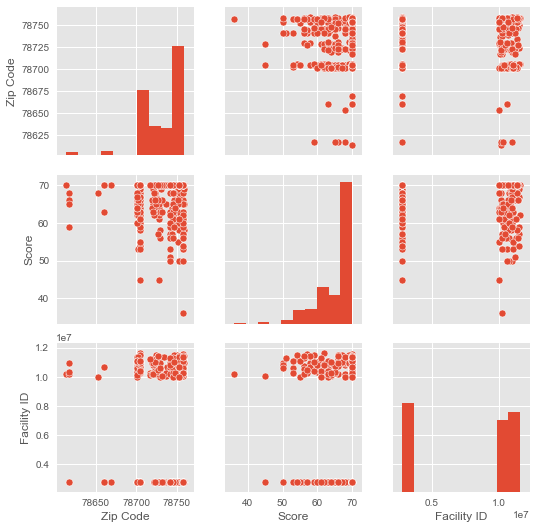

In [247]:
sns.pairplot(dirties[["Zip Code", "Score", "Facility ID"]])

In [69]:
from mpl_toolkits.basemap import Basemap

/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


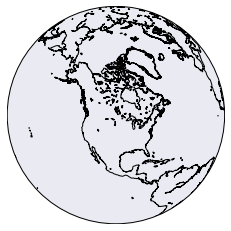

In [70]:
map = Basemap(projection='ortho', lat_0=50, lon_0=-100,
              resolution='l', area_thresh=1000.0)
 
map.drawcoastlines()
 
plt.show()

In [75]:
# m = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
#       urcrnrlat=49, projection='lcc', lat_1=30.307182,
#       lon_0= -97.755996, resolution='h', area_thresh=10000)

In [77]:
m = Basemap(lat_1=30.307182, lon_0= -97.755996)

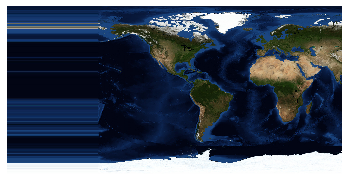

In [78]:
m.bluemarble()


/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


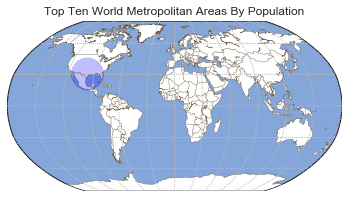

In [81]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

# lon_0 is central longitude of robinson projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='robin',lon_0=0,resolution='c')
#set a background colour
m.drawmapboundary(fill_color='#85A6D9')

# draw coastlines, country boundaries, fill continents.
m.fillcontinents(color='white',lake_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawcountries(color='#6D5F47', linewidth=.4)

# draw lat/lng grid lines every 30 degrees.
m.drawmeridians(np.arange(-180, 180, 30), color='#bbbbbb')
m.drawparallels(np.arange(-90, 90, 30), color='#bbbbbb')

# lat/lon coordinates of top ten world cities
lats = [30.3]
lngs = [-97.76]
#populations = [32.45,20.55,20.45,19.75,19.2,18.9,18.85,18.6,17.375,16.65] #millions

# compute the native map projection coordinates for cities
x,y = m(lngs,lats)

#scale populations to emphasise different relative pop sizes
s_populations = [p * p for p in populations]

#scatter scaled circles at the city locations
m.scatter(
    x,
    y,
    s=s_populations, #size
    c='blue', #color
    marker='o', #symbol
    alpha=0.25, #transparency
    zorder = 2, #plotting order
    )

# # plot population labels of the ten cities.
# for population, xpt, ypt in zip(populations, x, y):
#     label_txt = int(round(population, 0)) #round to 0 dp and display as integer
#     plt.text(
#         xpt,
#         ypt,
#         label_txt,
#         color = 'blue',
#         size='small',
#         horizontalalignment='center',
#         verticalalignment='center',
#         zorder = 3,
#         )
        
#add a title and display the map on screen
plt.title('Top Ten World Metropolitan Areas By Population')
plt.show()

In [248]:
%matplotlib inline

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

X, y = make_blobs(
    n_samples    =  200, 
    centers      =  3, 
    n_features   =  2,
    random_state =  364
)


dirty_cluster = pd.DataFrame(X, columns=['Zip Code', 'Score'])
dirty_cluster.head()


,Zip Code,Score
0,-5.716626,7.865418
1,-2.081026,-7.708825
2,-8.057452,-7.008271
3,-9.571572,-7.820384
4,-9.144392,-6.988266


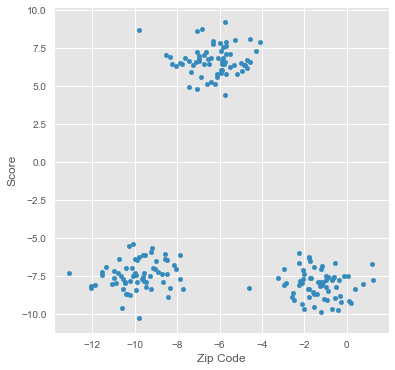

In [249]:
dirty_cluster.plot(kind="scatter", x="Zip Code", y="Score", figsize=(6, 6))

In [250]:
model = KMeans(n_clusters=3, random_state=0).fit(dirty_cluster)

In [251]:
predicted = model.labels_
centroids = model.cluster_centers_

print("Predicted clusters to points: ", predicted)
print("Location of centroids: ")
print(centroids)

Predicted clusters to points:  [1 2 0 0 0 1 2 0 1 0 0 0 2 0 1 0 1 2 0 1 2 2 0 1 0 1 1 1 1 2 2 1 1 2 0 2 0
 1 2 1 2 0 1 1 2 2 0 1 2 0 2 1 1 1 2 0 0 1 2 1 1 1 1 1 0 1 1 2 0 2 0 0 2 1
 2 2 1 2 2 2 1 1 2 0 0 2 1 0 0 1 2 2 0 1 2 0 1 2 1 2 0 0 1 2 0 2 1 2 0 0 2
 2 1 1 1 1 0 2 1 0 1 0 2 0 2 1 1 2 0 0 1 1 2 1 1 2 1 2 2 2 0 2 0 0 0 0 1 0
 0 1 1 1 0 0 2 0 1 2 0 1 1 2 0 0 2 2 2 1 0 2 0 2 0 2 2 1 0 0 2 2 2 0 1 2 1
 2 0 0 2 0 2 2 1 1 0 0 1 0 0 2]
Location of centroids: 
[[-9.8632446  -7.41752389]
 [-6.27227687  6.69264259]
 [-1.32507318 -8.03977692]]


In [252]:
dirty_cluster['predicted'] = predicted
dirty_cluster.head()

,Zip Code,Score,predicted
0,-5.716626,7.865418,1
1,-2.081026,-7.708825,2
2,-8.057452,-7.008271,0
3,-9.571572,-7.820384,0
4,-9.144392,-6.988266,0


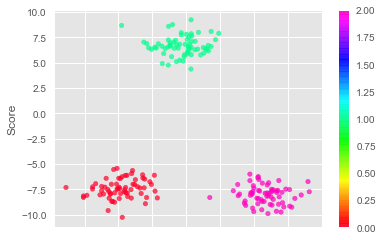

In [232]:
plt.figure(figsize=(7,7))
dirty_cluster.plot(x="Zip Code", y="Score", kind="scatter", c=df['predicted'], cmap='gist_rainbow', alpha=.7)
#plt.scatter(centroids[:,:1], centroids[:,1:], marker='x', s=150, alpha=.7, c=range(0,3), cmap='gist_rainbow')

In [233]:
inertia = model.inertia_
sil_score = silhouette_score(df, predicted, metric='euclidean')

print('Inertia          = ', inertia)
print('Silhouette score = ', sil_score)

Inertia          =  408.042323215
Silhouette score =  0.822362200848


In [262]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [1]:
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

NameError: name 'make_blobs' is not defined

For n_clusters = 2 The average silhouette_score is : 0.704978749608


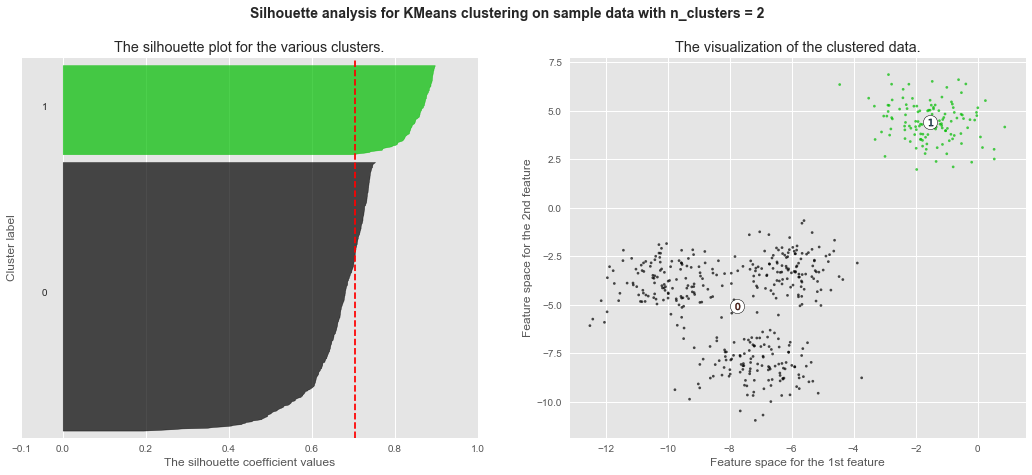

For n_clusters = 3 The average silhouette_score is : 0.588200401213


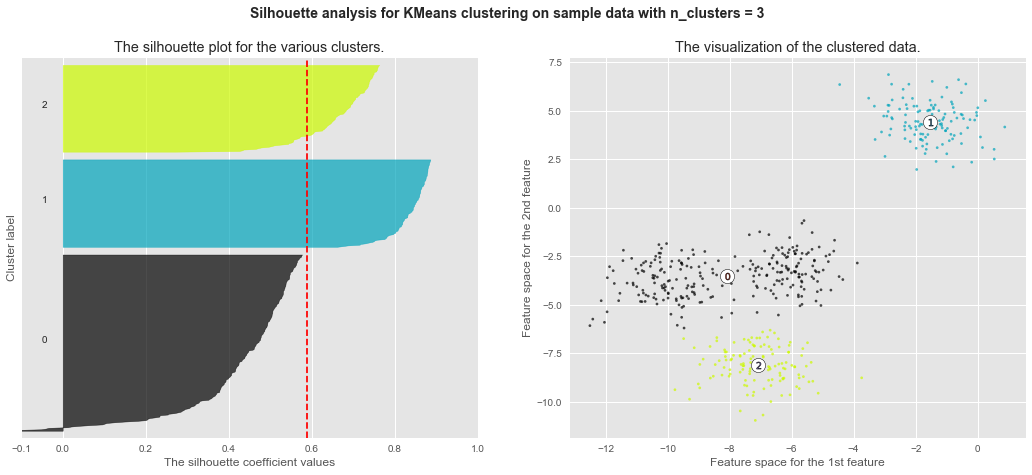

For n_clusters = 4 The average silhouette_score is : 0.650518663273


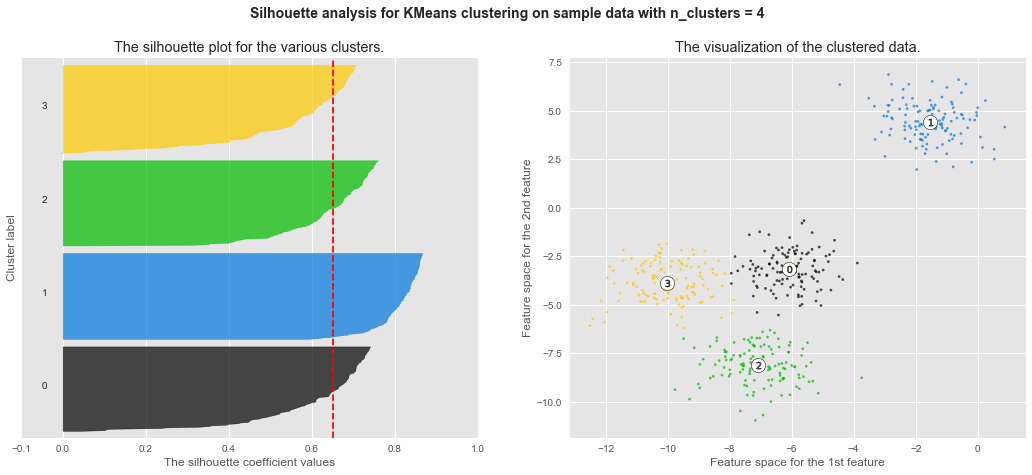

For n_clusters = 5 The average silhouette_score is : 0.563764690262


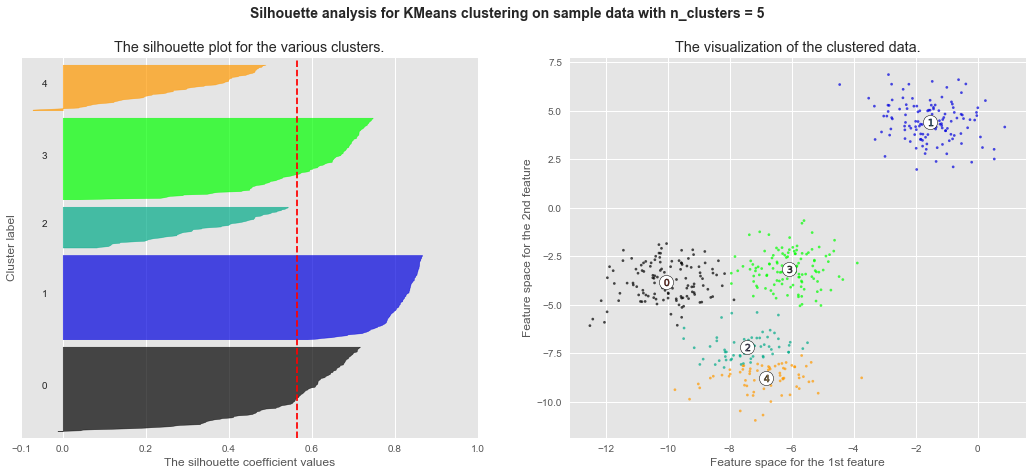

For n_clusters = 6 The average silhouette_score is : 0.450466629437


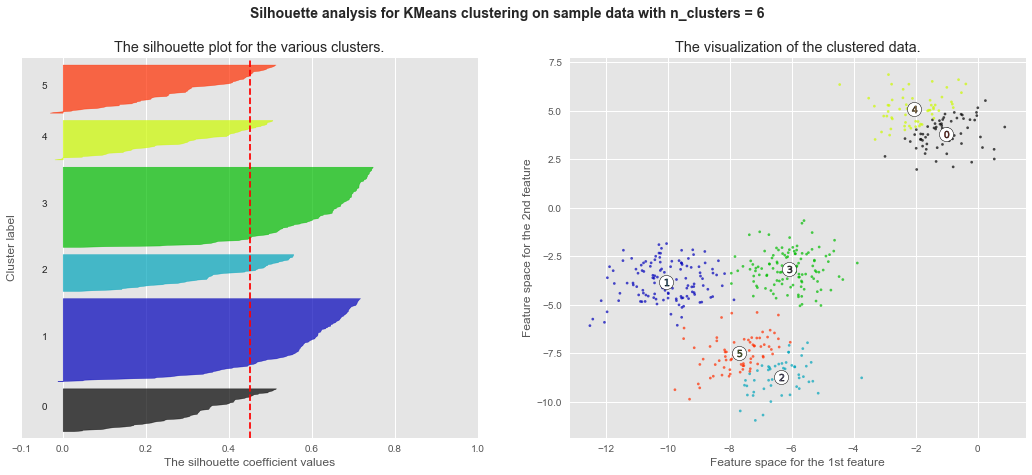

In [265]:

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
                # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [236]:
X="Zip Code"
y="Score"

AttributeError: 'str' object has no attribute 'shape'

In [235]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.33, random_state=75)

ValueError: Found input variables with inconsistent numbers of samples: [8, 5]

Automatically created module for IPython interactive environment


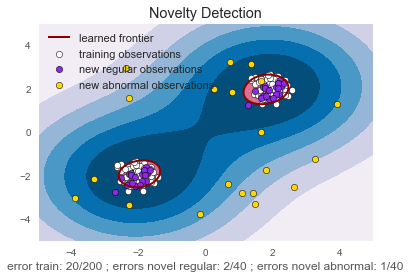

In [266]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [267]:
from sklearn.decomposition import PCA

In [269]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

[ 0.99244289  0.00755711]
[ 6.30061232  0.54980396]


Estimated number of clusters: 2
Homogeneity: 0.539
Completeness: 0.788
V-measure: 0.640
Adjusted Rand Index: 0.533
Adjusted Mutual Information: 0.538
Silhouette Coefficient: 0.449


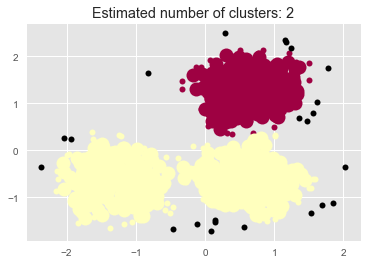

In [275]:

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=1975, )

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()